# Ensemble of different architectures

## Start

In [21]:
#Create references to important directories we will use over and over
import os, sys
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
from scipy.optimize import minimize_scalar
import time
import seaborn as sns
import keras
#from utils import *
from keras import backend as K
K.set_image_dim_ordering('tf')
%matplotlib inline
sns.set()

from PIL import Image
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, Input, Dropout
from keras.applications import xception
from keras.optimizers import SGD, Adam

import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [4]:
current_dir = os.getcwd()
DATA_HOME_DIR = current_dir+'/data/dogscats'

path = DATA_HOME_DIR + '/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path = DATA_HOME_DIR + '/results/'
predictions_path = DATA_HOME_DIR + '/results/predictions/'
train_path = path + '/train/'
valid_path = path + '/valid/'
model_path = path + '/models/'

## Generate augmented images to bottleneck from

In [3]:
def generate_augmented_images(input_shape=(299, 299, 3), batch_size=20, aug_mult=1):
    train_aug_dir = 'train_aug_'+'x'.join(map(str, input_shape))  # train_aug_3x299x299

    train_gen = image.ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         shear_range=0.1,
                                         zoom_range=0.1,
                                         horizontal_flip=True)

    train_batches = train_gen.flow_from_directory(train_path,
                                                  shuffle=False,        ###############
                                                  batch_size=batch_size, 
                                                  class_mode='categorical', 
                                                  target_size=input_shape[:-1])
    
    # create dirs for each class
    %cd $path
    for fn in set(map(os.path.dirname, train_batches.filenames)):
        os.makedirs(f'{train_aug_dir}/{fn}', exist_ok=True)
        
    
    for i in enumerate(tqdm(range(int(train_batches.samples/train_batches.batch_size*aug_mult)))):
        batch = train_batches.next()
        idx = ((train_batches.batch_index - 1)*train_batches.batch_size)%train_batches.samples
        filenames = train_batches.filenames[idx:idx+train_batches.batch_size]

        # TODO:
        assert len(filenames) == len(batch[0]), 'train_batch.samples is not divisible by batch_size'

        for img, filename in zip(batch[0], filenames):
            new_filename = f'{path}/{train_aug_dir}/{filename.split(".jpg")[-2]}.{i[0]}.jpg'
            Image.fromarray(img.swapaxes(1, 2).transpose().astype('uint8')).save(new_filename)

In [4]:
generate_augmented_images(aug_mult=5)

Found 23000 images belonging to 2 classes.
C:\Python\AI\data\dogscats


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5750/5750 [52:36<00:00,  1.82it/s]


In [ ]:
from keras.applications.xception.

## Generate bottlenecks

In [43]:
def generate_bottlenecks(MODEL=xception.Xception, input_shape=(299, 299, 3), batch_size=20, preprocess=xception.preprocess_input, aug_mult=5):
    train_aug_dir = 'train_aug_'+'x'.join(map(str, input_shape))  # train_aug_3x299x299
    # generator will load augmented samples
    gen = image.ImageDataGenerator()
    train_batches = gen.flow_from_directory(path+train_aug_dir,
                                            shuffle=False,
                                            batch_size=batch_size, 
                                            class_mode='categorical', 
                                            target_size=input_shape[:-1])
    valid_batches = gen.flow_from_directory(valid_path,
                                            shuffle=False,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            target_size=input_shape[:-1])
    test_batches = gen.flow_from_directory(test_path,
                                           shuffle=False,
                                           batch_size=batch_size,
                                           class_mode=None,
                                           target_size=input_shape[:-1])

    # preprocess input using builtin keras function
    x = keras.layers.Input(input_shape)
    if preprocess:
        x = keras.layers.Lambda(preprocess)(x)

    model = MODEL(include_top=False, 
                  weights='imagenet', 
                  input_tensor=x, 
                  input_shape=input_shape, 
                  pooling='avg')
    # save conv predictions after avg pooling layer as features
    # train set - images and labels
    train_features = model.predict_generator(train_batches, train_batches.n/train_batches.batch_size, verbose=1)
    save_array(f'{model_path}/{MODEL.__name__}_train_features.bc', train_features)
    save_array(f'{model_path}/{MODEL.__name__}_train_labels.bc', train_batches.classes)
    
    # validation set - images, labels and filenames
    valid_features = model.predict_generator(valid_batches, valid_batches.n/valid_batches.batch_size, verbose=1)
    save_array(f'{model_path}/{MODEL.__name__}_valid_features.bc', valid_features)
    save_array(f'{model_path}/{MODEL.__name__}_valid_labels.bc', valid_batches.classes)
    save_array(f'{model_path}/{MODEL.__name__}_valid_filenames.bc', valid_batches.filenames)
    
    # test set - images and filenames(ids)
    test_features = model.predict_generator(test_batches, test_batches.n/test_batches.batch_size, verbose=1)
    save_array(f'{model_path}/{MODEL.__name__}_test_features.bc', test_features)
    save_array(f'{model_path}/{MODEL.__name__}_test_filenames.bc', list(map(lambda filename: 
                                                                               int(filename[8:].split('.jpg')[-2]), 
                                                                            test_batches.filenames)))
    
generate_bottlenecks(MODEL=xception.Xception, input_shape=(299, 299, 3), batch_size=20, preprocess=xception.preprocess_input, aug_mult=5)

#### Dirty hack for now

In [153]:
MODEL=xception.Xception
input_shape=(299, 299, 3)
batch_size=20
preprocess=xception.preprocess_input
aug_mult=5

train_aug_dir = 'train_aug_'+'x'.join(map(str, input_shape))  # train_aug_3x299x299
gen = image.ImageDataGenerator()
valid_batches = gen.flow_from_directory(valid_path,
                                            shuffle=False,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            target_size=input_shape[:-1])


save_array(f'{model_path}/{MODEL.__name__}_valid_filenames.bc', valid_batches.filenames)

Found 2000 images belonging to 2 classes.


## Make a new model

In [154]:
def get_features(MODEL=xception.Xception):
    train_features = load_array(f'{model_path}/{MODEL.__name__}_train_features.bc')
    train_labels = load_array(f'{model_path}/{MODEL.__name__}_train_labels.bc')
    valid_features = load_array(f'{model_path}/{MODEL.__name__}_valid_features.bc')
    valid_labels = load_array(f'{model_path}/{MODEL.__name__}_valid_labels.bc')
    valid_filenames = load_array(f'{model_path}/{MODEL.__name__}_valid_filenames.bc')
    test_features = load_array(f'{model_path}/{MODEL.__name__}_test_features.bc')
    test_filenames = load_array(f'{model_path}/{MODEL.__name__}_test_filenames.bc')
    return (train_features, train_labels, 
           valid_features, valid_labels, valid_filenames, 
           test_features, test_filenames)

(train_features, train_labels, 
 valid_features, valid_labels, valid_filenames, 
 test_features, test_filenames) = get_features(xception.Xception)

In [ ]:
Resnet = keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling='avg')

In [75]:
# new model
#train_features = keras.layers.Input((2048,))
model = keras.models.Sequential()
dropout_p = 0.5

model.add(Dense(2048, input_shape=(2048,), activation='relu'))
model.add(Dropout(dropout_p))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(dropout_p))
model.add(Dense(2, activation='softmax'))

model.compile(Adam(lr=0.002), 'categorical_crossentropy', metrics=['acc'])

In [78]:
model.fit(train_features, train_labels, batch_size=10000, epochs=1, validation_data=(valid_features, valid_labels))

Train on 138000 samples, validate on 2000 samples
Epoch 1/1
138000/138000 [==============================] - 5s - loss: 0.0134 - acc: 0.9951 - val_loss: 0.0184 - val_acc: 0.9965


In [86]:
model.compile(SGD(lr=0.001), 'categorical_crossentropy', metrics=['acc'])
model.fit(train_features, train_labels, batch_size=1000, epochs=1, validation_data=(valid_features, valid_labels))

Train on 138000 samples, validate on 2000 samples
Epoch 1/1
138000/138000 [==============================] - 8s - loss: 0.0123 - acc: 0.9955 - val_loss: 0.0184 - val_acc: 0.9965


In [185]:
model.evaluate(valid_features, valid_labels)

1984/2000 [============================>.] - ETA: 0s

[0.01835887362380163, 0.99650000000000005]

In [187]:
model.save_weights(results_path+'xc_bnda6_v0.0184_5.h5')

In [94]:
test_preds = model.predict(test_features, batch_size=10000)
valid_preds = model.predict(valid_features, batch_size=10000)

In [130]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    import itertools
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(classes))
    tick_marks = []
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [102]:
valid_labels.astype('float32')

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]], dtype=float32)

In [117]:
valid_labels[:, 1].astype('int')

array([0, 0, 0, ..., 1, 1, 1])

dtype('float32')

[[997   3]
 [  4 996]]


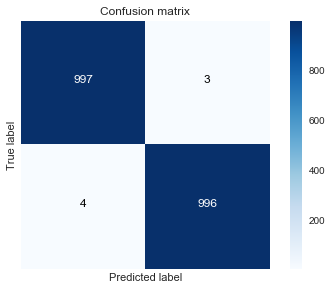

In [139]:
isdog = test_preds[:, 1]
val_isdog = valid_preds[:, 1]
val_predicted_labels = np.round(val_isdog)
val_expected_labels = valid_labels[:, 1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_expected_labels, val_predicted_labels)
plot_confusion_matrix(cm, ['cat', 'dog'])

In [161]:
from keras.preprocessing import image
from numpy.random import permutation
#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots(ims, figsize=(24,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + valid_filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 8

In [151]:
incorrect[0]

59

In [152]:
valid_batches

Found 7 incorrect labels


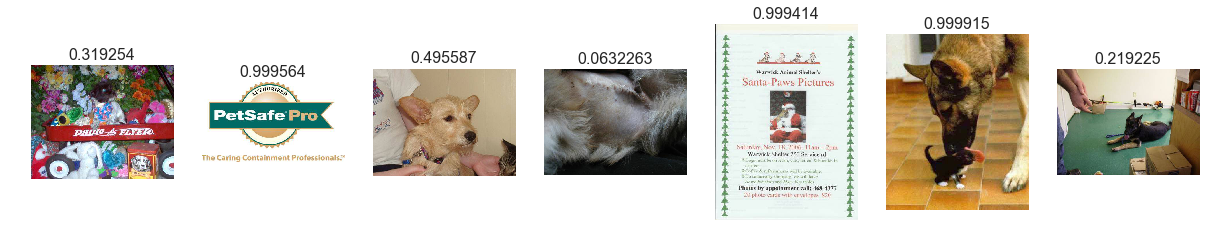

In [163]:
#2. A few incorrect labels at random
incorrect = np.where(val_expected_labels!=val_predicted_labels)[0]
print(f"Found {len(incorrect)} incorrect labels")
idx = permutation(incorrect)[:n_view]
plots_idx(idx, val_isdog[idx])

In [178]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
print('precision:', precision_score(val_expected_labels, val_predicted_labels)) 
print('recall:', recall_score(val_expected_labels, val_predicted_labels)) 
print('accuracy:', accuracy_score(val_expected_labels, val_predicted_labels))

precision: 0.996996996997
recall: 0.996
accuracy: 0.9965


In [180]:
import scipy
min_logloss = scipy.optimize.minimize_scalar(lambda x: log_loss(val_expected_labels, val_isdog, eps=x), bounds=(1e-10, 0.1), method='bounded')
min_logloss

     fun: 0.017171101232001093
 message: 'Solution found.'
    nfev: 14
  status: 0
 success: True
       x: 0.0016025209466791722

In [183]:
eps = np.clip(min_logloss.x, 0.001, 0.05)
min_logloss_f = log_loss(val_expected_labels, val_isdog, eps=eps)
isdog = isdog.clip(min=eps, max=1-eps)

In [184]:
subm = np.stack([test_filenames, isdog], axis=1)
%cd $DATA_HOME_DIR
submission_file_name = 'submission12.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')
pd.read_csv(submission_file_name, index_col='id')

C:\Python\AI\data\dogscats


,label
id,
1,0.99840
10,0.00160
100,0.00160
1000,0.99840
10000,0.99840
10001,0.00160
10002,0.00160
10003,0.99840
10004,0.99840


In [190]:
submission_message = f"Xception convnet with BN and DAx6 bottlenecks -- xc_bnda6_v0.0184_5.h5 logloss={min_logloss_f:.5} eps={eps:.5}"
!kg submit $submission_file_name -m "$submission_message"

0.04300
